Начнём с подготовки данных на основе набора MovieLens. У нас есть две таблицы: movies (информация о фильмах) и ratings (оценки пользователей). Загрузим их и посмотрим первые строки для понимания структуры данных:


In [3]:
import pandas as pd

movies = pd.read_csv('data/lightFM/movies.csv')      # содержит колонки: movieId, title, genres
ratings = pd.read_csv('data/lightFM/ratings.csv')    # содержит колонки: userId, movieId, rating, datetime
ratings = ratings.drop(["Unnamed: 0"],axis=1)

print("-----------MOVIE-INFO-----------")
print(movies.head(2), '\n\n')
print("-----------MOVIE-RATING-----------")
print(ratings.head(2))


-----------MOVIE-INFO-----------
   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy 


-----------MOVIE-RATING-----------
   userId  movieId  rating             datetime
0       1        1     4.0  2000-07-30 18:45:03
1       1        3     4.0  2000-07-30 18:20:47


Преобразование рейтингов в имплицитные взаимодействия: Поскольку мы собираемся обучать модель с функцией потерь WARP, которая предназначена для импlicitного фидбэка, нам важно сконцентрироваться на факте взаимодействия (просмотра/оценки), а не на конкретном числовом значении рейтинга. В WARP все наблюдаемые взаимодействия считаются положительными сигналами, а ненаблюдаемые - отрицательными. Поэтому мы преобразуем данные рейтингов в бинарные имплицитные взаимодействия. Один из подходов – выбрать порог рейтинга, выше которого считать взаимодействие положительным. Например, будем считать, что рейтинг ≥ 4.0 означает, что пользователю фильм понравился (положительное взаимодействие):


In [4]:
# Фильтруем рейтинги: оставляем только рейтинги 3
positive_ratings = ratings[ratings['rating'] >= 3.0].copy()

# Присваиваем вес 1 всем отобранным взаимодействиям (имплицитная обратная связь)
positive_ratings['rating'] = 1.0

# Переименовываем колонки для совместимости с RecTools (user_id, item_id, weight)
positive_ratings.rename(columns={'userId': 'user_id', 'movieId': 'item_id', 
                                 'rating': 'weight'}, inplace=True)
positive_ratings.head(3)


,user_id,item_id,weight,datetime
0,1,1,1.0,2000-07-30 18:45:03
1,1,3,1.0,2000-07-30 18:20:47
2,1,6,1.0,2000-07-30 18:37:04


Теперь каждая строка в positive_ratings – это факт взаимодействия пользователя с фильмом (вес 1 означает положительное событие). Пользователи, у которых нет рейтингов ≥3, будут исключены из обучающих данных (их можно будет считать холодными пользователями при рекомендациях).


Подготовка признаков фильмов (контентные фичи): Наша рекомендательная система будет гибридной, то есть сочетать коллаборативную фильтрацию (учёт взаимодействий пользователь-фильм) и контентные признаки (атрибуты фильмов). В качестве контентных признаков мы возьмём жанры фильмов. У каждого фильма в movies['genres'] перечислен список жанров через |. Преобразуем это в формат, удобный для модели:
Разобьём строку жанров на отдельные жанры.Создадим таблицу признаков фильмов item_features_df с колонками: id (movieId фильма), value (название жанра) и feature (тип признака, здесь всегда "genre").


In [5]:
# Разбиение жанров на списки
movies['genre_list'] = movies['genres'].str.split('|')

# Создаём DataFrame с признаками жанров для фильмов
item_features_df = movies[['movieId', 'genre_list']].explode('genre_list')
item_features_df.columns = ['id', 'value']        # id = movieId, value = жанр
item_features_df['feature'] = 'genre'            # тип признака – "genre"
print(item_features_df.head(5))


   id      value feature
0   1  Adventure   genre
0   1  Animation   genre
0   1   Children   genre
0   1     Comedy   genre
0   1    Fantasy   genre


Чтобы объективно оценивать модель, разделим имеющиеся положительные взаимодействия на обучающую и тестовую часть. Правильное разбиение гарантирует, что на тестовом наборе мы проверяем способность модели рекомендовать фильмы, которые пользователь ещё не видел в обучении. Мы можем выполнить, например, случайное разбиение по пользователям, чтобы у каждого пользователя часть фильмов осталась для теста. Один из подходов – для каждого пользователя отложить определённое количество (или долю) его взаимодействий в тест. В нашем примере отложим по 20% случайных взаимодействий каждого пользователя в тестовую выборку (предварительно убедившись, что у пользователя останутся взаимодействия в обучающей выборке):


In [6]:
from sklearn.model_selection import train_test_split

# Группируем по пользователю и делим для каждого
train_list = []
test_list = []
for user, user_data in positive_ratings.groupby('user_id'):
    if len(user_data) < 2:
        # если слишком мало взаимодействий, все оставляем в обучение (или пропускаем пользователя)
        train_list.append(user_data)
    else:
        # разбиваем для данного пользователя
        user_train, user_test = train_test_split(user_data, test_size=0.2, random_state=42)
        train_list.append(user_train)
        test_list.append(user_test)
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

print(f"Всего пользователей: {positive_ratings['user_id'].nunique()}")
print(f"Обучающих взаимодействий: {train_df.shape[0]}, Тестовых взаимодействий: {test_df.shape[0]}")

# После выполнения этого кода у нас есть:
	# train_df – DataFrame с позитивными взаимодействиями, используемый для обучения.
	# test_df – DataFrame с позитивными взаимодействиями, отложенный для тестирования.
# Важно: Ни один взаимодействий из test_df не присутствует в train_df. Таким образом, все фильмы из тестового набора для каждого пользователя не были ему рекомендованы во время обучения модели.

Всего пользователей: 609
Обучающих взаимодействий: 65175, Тестовых взаимодействий: 16588


Обучение модели LightFM с WARP-loss
Теперь подготовим и обучим модель. Мы будем использовать библиотеку LightFM (с обёрткой RecTools для удобства), которая реализует гибридные рекомендательные модели. Модель LightFM позволяет учитывать как матрицу взаимодействий, так и дополнительные признаки пользователей или предметов (в нашем случае – жанры фильмов).


Создание набора данных для RecTools: RecTools предоставляет класс Dataset, упрощающий хранение взаимодействий и признаков. Создадим Dataset, передав в него обучающие взаимодействия, а также признаки фильмов:


In [8]:
from rectools.dataset import Dataset

# Создаём объект Dataset для RecTools
dataset = Dataset.construct(
    train_df, 
    item_features_df=item_features_df, 
    cat_item_features=['genre']  # указываем, что "genre" – категориальный признак (будет one-hot)
)

# train_df содержит колонки user_id, item_id, weight (вес взаимодействия). RecTools ожидает именно такие названия колонок.
# item_features_df – таблица признаков фильмов, которые мы подготовили (id фильма и жанры).
# cat_item_features=['genre'] указывает, что признак "genre" категориальный – RecTools преобразует жанры в one-hot векторы для передачи в модель.


Инициализация LightFM: Настроим модель LightFM. Мы выберем размер скрытых факторов (embedding) и функцию потерь WARP. WARP (Weighted Approximate-Rank Pairwise) – это функция потерь, оптимизирующая ранжирование позитивных примеров выше негативных. Особенность WARP в том, что она случайно пробует негативные примеры до тех пор, пока не найдёт такой, который неправильно outrank-ает позитивный, и обновляет веса, пропорционально числу пропущенных негативов. Такой подход фокусируется на улучшении precision@K, поскольку штрафует модель за каждый негативный элемент, оказавшийся выше позитивного в ранжировании. По сути, все взаимодействия считаются положительными, а неоцененные элементы – отрицательными, и модель учится присваивать более высокие прогнозные оценки позитивным парам пользователь-фильм и низкие – негативным.


In [10]:
from lightfm import LightFM
from rectools.models import LightFMWrapperModel

lightfm_model = LightFM(no_components=32, loss='warp', random_state=42)

model = LightFMWrapperModel(
    lightfm_model, 
    epochs=15,
    num_threads=4
)

model.fit(dataset)

Во время обучения модель проходит несколько эпох стохастического градиентного спуска. Каждая эпоха просматривает все наблюдения; WARP-loss будет стараться максимизировать разницу в оценках между взаимодействовавшими (positive) и не взаимодействовавшими (negative) парами. Мы используем num_threads=4 для параллелизма (если поддерживается), чтобы ускорить обучение. По завершении обучения у нас получится матричная факторизация, дополненная признаками жанров: у каждого пользователя и каждого фильма есть сгенерированные эмбеддинги (векторы скрытых факторов), а также учтены смещения (биасы) и влияния жанровых признаков. Благодаря гибридному подходу модель сможет делать рекомендации даже для фильмов, на которых мало данных, опираясь на их жанры, а также потенциально для новых пользователей, если известны их атрибуты (в нашем примере атрибутов пользователей нет, поэтому новые пользователи – "холодные", им можно рекомендовать популярные фильмы или использовать усреднённый профиль).


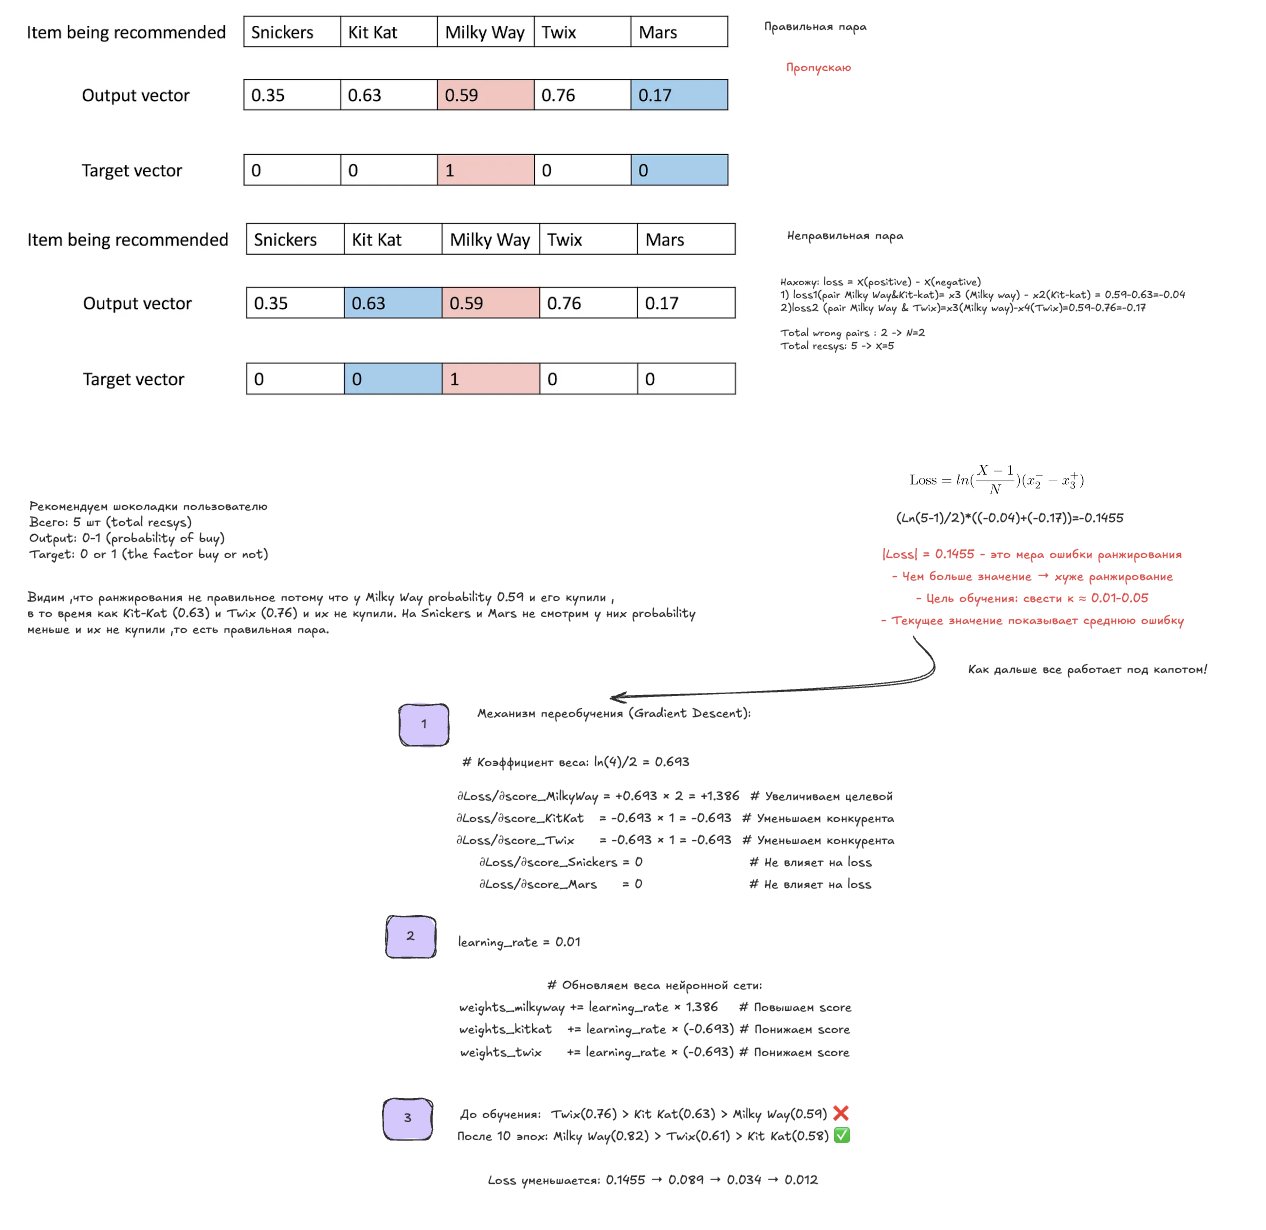

In [11]:
from IPython.display import Image, display
display(Image('schemas/warp_explanation.png'))

Другие виды loss function

| Loss-функция                                    | Тип данных            | Подходит для                                            | Скорость обучения | Учёт редких элементов (long-tail) |
| ----------------------------------------------- | --------------------- | ------------------------------------------------------- | ----------------- | --------------------------------- |
| **logistic** _(default)_                        | implicit или explicit | Общие рекомендации                                      | Средняя           | ❌ Нет                            |
| **bpr** _(Bayesian Personalized Ranking)_       | implicit              | Топ-N рекомендации                                      | Высокая           | ❌ Нет                            |
| **warp** _(Weighted Approximate-Rank Pairwise)_ | implicit              | Высокое качество top-N                                  | Средняя/низкая    | ❌ Нет                            |
| **warp-kos** _(WARP k-th Order Statistic)_      | implicit              | Улучшение рекомендаций для редких элементов (long-tail) | Средняя/низкая    | ✅ Да                             |


После обучения модели мы можем генерировать рекомендации. Мы сфокусируемся на пользователях из тестового набора (тех, у кого мы отложили часть взаимодействий). Для каждого такого пользователя получим топ-K фильмов, которых нет в их обучающих взаимодействиях (то есть фильмы, которые пользователь ещё не видел в обучающей выборке). В RecTools это делается методом model.recommend, куда мы передаем список нужных user_id и параметр filter_viewed=True (чтобы не рекомендовать фильмы, уже встречавшиеся в обучении):


In [12]:
# Список уникальных пользователей, присутствующих в тестовом наборе
test_users = test_df['user_id'].unique().tolist()

# Получим топ-10 рекомендаций для каждого пользователя из тестового списка
recommendations = model.recommend(
    users=test_users, 
    dataset=dataset, 
    k=10, 
    filter_viewed=True  # исключаем фильмы, которые пользователь уже видел (в train_df)
)

print(recommendations.head(10))


   user_id  item_id     score  rank
0        1      551 -0.149984     1
1        1      260 -0.320579     2
2        1     1196 -0.326854     3
3        1      588 -0.353799     4
4        1     1073 -0.516943     5
5        1     2028 -0.547811     6
6        1      589 -0.742537     7
7        1     1028 -0.795904     8
8        1     2193 -1.020418     9
9        1      364 -1.050153    10


### Отрицательные значения в score для модели LightFM — это нормальное явление.

### Почему так происходит?

### Модель LightFM выдает "не нормализованные" прогнозные значения. Они представляют собой внутренние оценки близости пользователя и товара, и могут быть как положительными, так и отрицательными.

### Важно понимать, что значение score само по себе не является вероятностью или абсолютной метрикой качества. Это просто численная величина, отражающая степень предпочтения относительно других элементов.

### При ранжировании элементы сортируются по этим значениям (от больших к меньшим), и абсолютное значение score не имеет принципиального значения.

### Что делать?

### Ничего менять не нужно, это абсолютно нормальное поведение LightFM.

### Единственное, что важно — это порядок элементов (rank), который модель определила исходя из этих оценок. Чем выше score, тем выше позиция в рекомендациях (даже если все они отрицательные).

### Ваш результат корректный, и вы можете спокойно продолжать работать с этим рейтингом для вычисления метрик Precision, Recall и NDCG.


#### Precision@K (точность на K) – доля рекомендованных фильмов в топ-K, которые оказались релевантными. В нашем случае "релевантные" для пользователя – это фильмы, которые реально присутствуют в его отложенном тестовом списке. Precision@K показывает, насколько "чисты" рекомендации (меньше нерелевантных фильмов в топ-K).

#### Recall@K (полнота на K) – доля релевантных фильмов, которые попали в топ-K рекомендаций. Эта метрика показывает, насколько хорошо рекомендации покрывают все интересы пользователя из тестового набора.

#### NDCG@K (Normalized Discounted Cumulative Gain) – нормализованная усечённая кумулятивная прибыль. Это метрика ранжирования, которая учитывает не только факт попадания релевантных объектов в рекомендации, но и их позиции. NDCG сравнивает фактический упорядоченный список рекомендаций с идеальным упорядочением, где все релевантные элементы стоят наверху списка. Значение NDCG нормализуется в диапазоне от 0 до 1, где 1 означает идеальное ранжирование (все релевантные фильмы вверху в верном порядке).

Для расчёта метрик нам нужно сравнить полученные рекомендации с ground truth – нашим тестовым набором test_df. Для каждого пользователя из теста мы знаем, какие фильмы он реально оценил (эти фильмы считаются релевантными для него). Мы посмотрим, сколько из этих фильмов попали в рекомендации (и на каких позициях). Рассчитаем метрики вручную:


In [13]:
import numpy as np

K = 10  # будем оценивать метрики @10, т.е. для топ-10 рекомендаций

# Создадим словарь реальных релевантных фильмов для каждого пользователя из теста
ground_truth = {
    user: set(group['item_id']) 
    for user, group in test_df.groupby('user_id')
}

# Подготовим списки для накопления метрик по каждому пользователю
precision_scores = []
recall_scores = []
ndcg_scores = []

# Пройдёмся по каждому пользователю в тестовом наборе
for user, relevant_items in ground_truth.items():
    # Получим рекомендованные фильмы для этого пользователя (списком)
    user_recs = recommendations[recommendations['user_id'] == user]
    recommended_items = user_recs.sort_values('rank')['item_id'].tolist()
    
    # Если у пользователя меньше чем K рекомендаций (маленький каталог), дополним до K
    recommended_items = recommended_items[:K]
    
    # Считаем количество попаданий
    hits = sum(1 for item in recommended_items if item in relevant_items)
    precision = hits / K
    recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0.0
    
    # Расчёт DCG@K (Discounted Cumulative Gain)
    dcg = 0.0
    for rank, item in enumerate(recommended_items, start=1):
        if item in relevant_items:
            dcg += 1.0 / np.log2(rank + 1)
    # Расчёт IDCG@K (Ideal DCG для нормализации)
    ideal_hits = min(len(relevant_items), K)
    idcg = sum(1.0 / np.log2(rank + 1) for rank in range(1, ideal_hits + 1))
    ndcg = dcg / idcg if idcg > 0 else 0.0
    
    # Сохраняем метрики
    precision_scores.append(precision)
    recall_scores.append(recall)
    ndcg_scores.append(ndcg)

# Усредняем метрики по всем пользователям
precision_at_k = np.mean(precision_scores)
recall_at_k = np.mean(recall_scores)
ndcg_at_k = np.mean(ndcg_scores)

print(f"Precision@{K}: {precision_at_k:.4f}")
print(f"Recall@{K}:    {recall_at_k:.4f}")
print(f"NDCG@{K}:      {ndcg_at_k:.4f}")


Precision@10: 0.2379
Recall@10:    0.1339
NDCG@10:      0.2758
